# Similarity through histogram


## What is a Histogram?

A histogram is a graphical representation of the distribution of numerical data. It is an estimate of the probability distribution of a continuous variable (in this case, pixel values in an image). In the context of image processing, a histogram represents how the pixel values (intensities) are distributed in an image. This is usually displayed in a 2D plot, with the occurences depending on the color values of the image


### Example
Lets take the following Image as an Example to explain Histograms.

<img src="0802.png" style="width:35%; height:35%;"/>



Let's assume we're working in the RGB color space. Three separate histograms would be created, one for each color channel: Red, Green, and Blue.

### Each histogram counts how often each color value (ranging from 0 to 255) occurs in the respective channels. For the green fruits in the image, the values in the Green channel would likely be higher, while the Red and Blue values might be lower. 

Let's take a look at the histograms

In [1]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = 'DIV2k/DIV2K_valid_HR/DIV2K_valid_HR/0802.png'
image = cv2.imread(image_path)

if image is not None:
    # Convert image to RGB (from BGR which OpenCV uses by default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate and plot histograms for each color channel separately
    colors = ('r', 'g', 'b')
    channels = ('Red', 'Green', 'Blue')

    plt.figure(figsize=(18, 6))

    for i, color in enumerate(colors):
        plt.subplot(1, 3, i + 1)
        hist = cv2.calcHist([image_rgb], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
        plt.title(f'{channels[i]} Histogram')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.grid(True)  # Add grid for better visualization

    plt.tight_layout()
    plt.show()

else:
    print("Failed to load the image. Please check the file path.")


Failed to load the image. Please check the file path.


As expected, a very large proportion of the pixels in the image have a blue value of 0, while the green values tend to dominate within the image. 

### RGB Channel are not effective


Now all you have to do is create and save 3 histograms for each channel for all 450,000 images in the database and you're done. Well, not quite...

The problem with this approach is that the RGB color space is based on the mixture of light colors, which is less intuitive when it comes to comparing colors from a human perspective. For example a brighter picture that is still the same picture could have completely other histograms, which will be visible especially in the red channel. Let's test it out.

<img src="0802-bright.png" style="width:35%; height:35%;"/>

![alt text](0802-bright-histogram-1.png)

According to the histograms, we should be able to see a lot more red tones in the image, but this is not the case, as we are analyzing a just brighter version of the image before. So why is that?

Changing the brightness not only brings more white tones into the picture, but also brighter yellow tones, which are primarily mixed with the red and green channel. In addition, the green tones have also become stronger, which is responsible for the deflection in the histogram of the green channel. So according to the histograms, we have 2 completely different images here, while we humans can clearly establish a similarity despite the differences in brightness, as the same colors are used.



### What is the solution?


Let's first start the coding part. For this Notebook we need the following Imports

In [2]:

# necessary imports
import os
import sqlite3
from PIL import ImageCms
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from sklearn.neighbors import NearestNeighbors
import joblib
import functions
from sklearn.neighbors import NearestNeighbors


icms = ImageCms

## Connection with the database

Here we establish a connection with the database that contains all the images from the hard disk.

The image properties that we save from the image are:

- Name
- Storage Path
- Pixel size

In [3]:
# Connect to an existing one to store image metadata
database_name = "database_all_images.db"
root_folder = r"D:/data/image_data"

conn = sqlite3.connect(database_name)
c = conn.cursor()
conn.commit()



## Storing the storage path of every image in a variable
This helps us to find and plot the similar images later in the code.

In [4]:
# Fetch image paths from the database to work with the image files
# Execute the query to select all paths from the Images table
c.execute("SELECT Path FROM Images")

# Fetch all results
paths_tuples = c.fetchall()  # This will be a list of tuples

# Convert list of tuples to a list of strings
database_image_paths = [path[0] for path in paths_tuples]  # Extract the first element of each tuple

# Verify the paths
for path in database_image_paths[:10]:  # Print the first 10 paths for verification
    print(path)


D:/data/image_data\weather_image_recognition\dew\2208.jpg
D:/data/image_data\weather_image_recognition\dew\2209.jpg
D:/data/image_data\weather_image_recognition\dew\2210.jpg
D:/data/image_data\weather_image_recognition\dew\2211.jpg
D:/data/image_data\weather_image_recognition\dew\2212.jpg
D:/data/image_data\weather_image_recognition\dew\2213.jpg
D:/data/image_data\weather_image_recognition\dew\2214.jpg
D:/data/image_data\weather_image_recognition\dew\2215.jpg
D:/data/image_data\weather_image_recognition\dew\2216.jpg
D:/data/image_data\weather_image_recognition\dew\2217.jpg


## Now to the solution

Instead of using the RGB color space, we use the HSV color space.

In the HSV color space, the color components (hue, saturation) are separated from the brightness (value). This means that changes in brightness (e.g. lighting) do not affect the hue information (Hue), which is basically the actual color of the image. 
Let's have a look at the same example from above and plot the HSV histogram.

<img src="0802.png" style="width:35%; height:35%;"/>


![alt text](0802-histogram-hsv-2.png)

What we can see on the histograms is that a lot of pixels in the image are in the 20-50 range. The saturation of the colors within this spectrum is often very high, which makes for strong vibrant colors contained in the image. Value describes how bright or dark the pixel is, where 0 is very dark and 255 is very bright. The fact that some pixels are rather dark, as can be seen from the plot, makes sense due to the spatial division of the fruit, which creates shadows.

Why can we now work better with it than with RGB?


## Hue and Saturation

![alt text](Hue-1.png)

In this plot, the hue is plotted on the x-axis and the saturation on the y-axis. This diagram contains most of the colors that we can see with the human eye. Unlike the RGB color space, no colors are mixed here; instead, each possible color has its own value on the Hue axis. The strength of this color is shown in the Saturation axis. 

If we apply the values from above to this diagram, we can see that the yellow tones dominate in the image. According to the histograms, there are also a few green tones in the image. How bright or dark these green tones are plays nearly no role in either the hue or the saturation, as the brightness or darkness is determined by the V, i.e. the value. 

How do we apply these insights to our project?

## The Heart for this Methood

This is the key function to create the histograms that will be stored in a pickle file

```python
def calculate_histogram(image, color_space):
    if color_space == "HSV":
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1], None, [32, 32], [0, 180, 0, 256])  # Interesting part of the function
        
    elif color_space == "RGB":
        hist = cv2.calcHist([image], [0, 1, 2], None, [32, 32, 32], [0, 256, 0, 256, 0, 256])
    else:
        pass

    hist = cv2.normalize(hist, hist).flatten()
    return hist
```

This line is the interesting part of this function:
```python
hist = cv2.calcHist([hsv], [0, 1], None, [32, 32], [0, 180, 0, 256]) 
```
We compute a 2D histogram for the input image in the HSV color space. The histogram represents the joint distribution of the Hue and Saturation values in the image, with 32 bins for each channel. The Hue values will be between 0 and 180 while the Saturation Values will be between 0 and 256. This 2D histogram captures the color information in a compact form, which will be used later for the image comparison based on color similarity.

After that we normalize the histogram, to ensure that the histogram values are on a consistent scale, which is particularly important when comparing histograms from different images. For example, two images of different sizes will have histograms with different raw counts, but normalization will scale them so they can be meaningfully compared. With ```.flatten()``` we also convert the histogram from a multi-dimensional array to a one-dimensional array, which is necessary for the nearest neighbor search when trying to search for similar images.

Let's have a look at the other functions.


In [5]:
# Calculate the histogram of an image using OpenCV
# The cv2.calcHist function computes the histogram for the given image
# In this context, histograms are used to compare images and determine similarity
def calculate_histogram(image, color_space):
    """
    This function computes the color histogram of an image in a specified color space, either HSV or RGB. 

    Input:
    - image: A single image represented as a NumPy array. This is the image whose histogram will be calculated.
    - color_space: A string indicating the color space to be used for the histogram calculation. It can be either "HSV" or "RGB"

    Output:
    - hist: A flattened, normalized histogram of the image, represented as a one-dimensional NumPy array.

    The image is converted from BGR (default OpenCV format) to HSV color space using cv2.cvtColor.
    Then, the histogram is calculated for the Hue and Saturation channels with 32 bins for each using cv2.calcHist. 
    The histogram is then normalized to ensure that the comparison between histograms is not biased by the size of the images.
    Finally, the normalized histogram is flattened into a one-dimensional array.
    
    """

    if color_space == "HSV":
        #The image is converted from BGR (default OpenCV format) to HSV color space
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1], None, [32, 32], [0, 180, 0, 256])  
    elif color_space == "RGB":
        hist = cv2.calcHist([image], [0, 1, 2], None, [32, 32, 32], [0, 256, 0, 256, 0, 256]) 
    else:
        pass

    hist = cv2.normalize(hist, hist).flatten()
    return hist



def process_image(image_path):
    """
    This function processes an image from a given path, calculates its histogram using the calculate_histogram function, and returns the path along with the histogram.

    Input: 
    - image_path: A string representing the file path of the image to be processed.

    Output:
    - A tuple with the image path and the corresponding histogram. If the image cannot be loaded, it returns 

    The image is read from the specified path using cv2.imread.
    If the image is successfully loaded (i.e., it is not None), the function calculates the histogram using the "HSV" color space.
    The function then returns a tuple containing the image path and the computed histogram.
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is not None:
        # Getting the histogram for that image in HSV color space
        hist = calculate_histogram(image, "HSV")
        return (image_path, hist)
    return None




def load_histograms(save_path):
    """
    This function loads previously computed histograms from a pickle file if it exists. This allows the program to have access on every computed histogramm for every image.

    Input:
    - save_path: A string representing the file path where the histograms are saved.

    Output:
    - A dictionary where the keys are image paths and the values are their corresponding histograms.
    
    The function checks if the specified file exists.
    If the file exists, it loads the histograms using joblib.load (a method used for serializing Python objects).
    If the file does not exist, it returns an empty dictionary.

    """
    if os.path.exists(save_path):
        with open(save_path, 'rb') as f:
            histograms = joblib.load(f)
    else:
        histograms = {}
    return histograms




def compute_and_store_histograms(database_image_paths, save_path, save_interval=10000):
    """
    This function computes histograms for a list of images and periodically saves the results to a pickle file to avoid losing progress.

    Input:
    - database_image_paths: A list of strings, where each string is the file path of an image in the database.
    - save_path: A string representing the file path where histograms will be saved.
    - save_interval: An integer that specifies how many histograms to compute before saving intermediate results (default is 10,000).

    Output:
    - The function doesn’t return anything explicitly, but it saves the computed histograms to the specified file.

    The function first loads any existing histograms using load_histograms.
    It determines which images have already been processed and skips them.
    Using a ThreadPoolExecutor, it processes images in parallel to speed up the computation. It calculates histograms for batches of images and adds them to the existing dictionary of histograms.
    After processing each batch (of size save_interval), it saves the updated histogram dictionary to the specified save_path using joblib.dump.


    """
    histograms = load_histograms(save_path)
    processed_paths = set(histograms.keys())

    remaining_paths = [path for path in database_image_paths if path not in processed_paths]
    
    start_index = 0
    if processed_paths:
        start_index = database_image_paths.index(remaining_paths[0])
    
    with ThreadPoolExecutor() as executor:
        for i in range(start_index, len(database_image_paths), save_interval):
            batch_paths = database_image_paths[i:i+save_interval]
            results = list(tqdm(executor.map(process_image, batch_paths), total=len(batch_paths)))
            for result in results:
                if result is not None:
                    histograms[result[0]] = result[1]

            # Save intermediate results
            joblib.dump(histograms, save_path)
            print(f"Saved {len(histograms)} histograms to {save_path}")




def load_histograms_from_file(file_path):
    """
    This function is a simple wrapper to load histograms from a file.

    Input:
    - file_path: A string representing the file path from where histograms will be loaded.

    Output:
    - A dictionary of histograms where the keys are image paths and the values are the corresponding histograms
    """
    histograms = joblib.load(file_path)
    return histograms




def find_similar_image(input_image, histograms, n_neighbors=1):
    """
    This function finds images in the database that are most similar to the input image based on color histograms.

    Input:
    - input_image: The image for which we want to find similar images. This is a NumPy array representing the image.
    - histograms: A dictionary where keys are image paths and values are the corresponding histograms.
    - n_neighbors: An integer specifying the number of similar images to return (default is 1).

    Output:
    - A list of tuples where each tuple contains an image path and the corresponding distance to the input image. The list is ordered by similarity, with the most similar image first.

    The histogram of the input image is calculated using the calculate_histogram function in the "HSV" color space.
    The function extracts the paths and histogram data from the histograms dictionary and prepares them for similarity search.
    A nearest neighbors search is performed using NearestNeighbors from the scikit-learn library. The search uses Euclidean distance as the similarity metric.
    The function retrieves the image paths and distances of the most similar images.

    """
    input_hist = calculate_histogram(input_image, "HSV")

    # Prepare data for nearest neighbors search
    paths = list(histograms.keys())
    hist_data = np.array(list(histograms.values()))

    # Use KDTree or BallTree for efficient similarity search
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric='euclidean').fit(hist_data)
    distances, indices = nbrs.kneighbors([input_hist])

    # Retrieve the most similar images
    similar_images = [(paths[idx], distances[0][i]) for i, idx in enumerate(indices[0])]
    return similar_images



 # List of paths to database images
database_histogram_file = "histograms_all_images_0608.pkl"


# Loading the histogram file and test the results

In [6]:
histograms = load_histograms_from_file(database_histogram_file)


## Possible Results:

After running the code in the next cell, this could be your results.

![alt text](output_example-1.png)

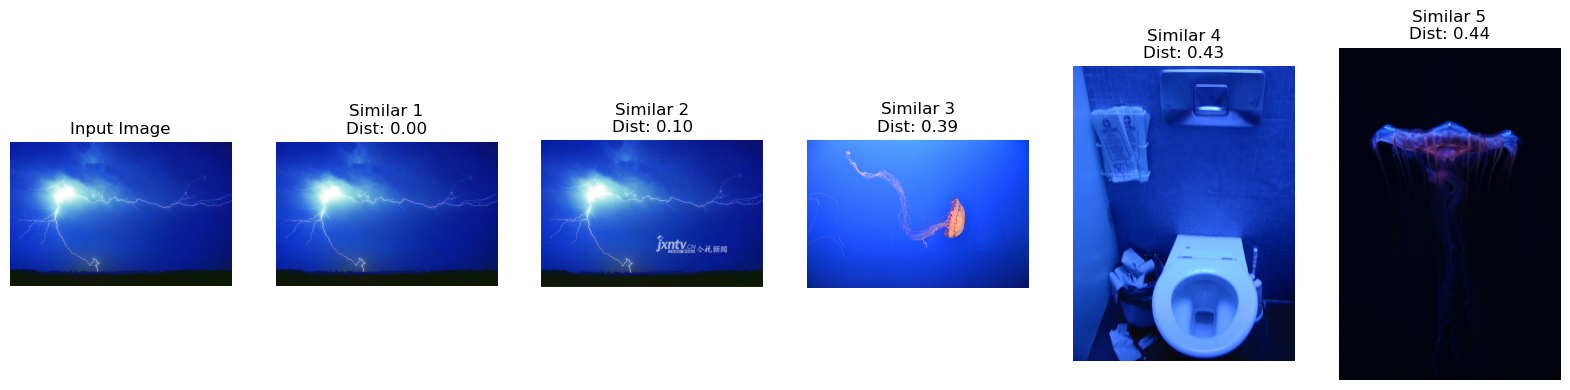

In [8]:

input_image_path = "images/1835.jpg"
input_image = cv2.imread(input_image_path)
similar_images = find_similar_image(cv2.imread(input_image_path), histograms, n_neighbors=5)
# Request top 3 similar images
functions.display_images(input_image_path, similar_images)


## Finding Similar Images with 5 Input Images

Now, we implemented a system to find images that are most similar to a given set of input images based on their color histograms and embeddings. The process involves three main steps: 
- calculating average histograms, 
- finding the most similar images based on these histograms, 
- and displaying the images for visualization. 

We first compute an average histogram that encapsulates the color characteristics of a set of input images. It then searches through a precomputed set of histograms for the entire dataset to find images that have similar color distributions to the input images. The top results are returned as the most similar images. Finally, these similar images are displayed for the user to review. 

In [9]:
def average_histograms(input_image_paths, color_space="HSV"):

    """
    This function calculates the average histogram of a list of input images.

    Input:
    - input_image_paths: A list of file paths to the input images.
    - color_space: The color space in which the histogram is calculated (default is "HSV").

    Output:
    - mean_histogram: A NumPy array representing the average histogram of the input images.
    """

    histograms = [calculate_histogram(cv2.imread(img_path), color_space) for img_path in input_image_paths]
    mean_histogram = np.mean(histograms, axis=0)
    return mean_histogram


def find_most_similar_to_average(input_image_paths, histograms, all_image_paths, top_n=5, color_space="HSV"):

    """
    This function finds the top N images in the dataset that are most similar to the average histogram
    of a given set of input images.

    Input:
    - input_image_paths: A list of file paths to the input images.
    - histograms: A dictionary where keys are image paths and values are their corresponding histograms.
    - all_image_paths: A list of paths to all images in the dataset.
    - top_n: Number of top similar images to return (default is 5).
    - color_space: The color space in which the histogram is calculated (default is "HSV").

    Output:
    - similar_images: A list of tuples, where each tuple contains the path of a similar image 
      and its corresponding distance to the average histogram. The list is ordered by similarity, 
      with the most similar image first.
    """

    mean_histogram = average_histograms(input_image_paths, color_space)
    
    # Prepare data for nearest neighbors search
    hist_data = np.array(list(histograms.values()))
    
    # Use KDTree or BallTree for efficient similarity search
    nbrs = NearestNeighbors(n_neighbors=top_n, algorithm='auto', metric='euclidean').fit(hist_data)
    distances, indices = nbrs.kneighbors([mean_histogram])
    
    # Retrieve the most similar images
    similar_images = [(all_image_paths[idx], distances[0][i]) for i, idx in enumerate(indices[0])]
    return similar_images


[('D:/data/image_data\\pexels_dataset_v1\\images_05\\soaring-seagulls-in-the-sky-1435849.jpeg', 0.6172059696186327), ('D:/data/image_data\\pixabay_dataset_v1\\images_06\\the-ball-stadion-football-court-488713.jpg', 0.6225772630472783), ('D:/data/image_data\\pixabay_dataset_v1\\images_03\\football-ball-sports-ground-gate-1486353.jpg', 0.6250205751847059), ('D:/data/image_data\\pixabay_dataset_v1\\images_03\\hill-door-basement-door-cellar-5423096.jpg', 0.6256428273773547), ('D:/data/image_data\\pixabay_dataset_v1\\images_02\\career-paper-origami-leader-marina-1738216.jpg', 0.6261075458572719)]
['D:/data/image_data\\pexels_dataset_v1\\images_05\\soaring-seagulls-in-the-sky-1435849.jpeg', 'D:/data/image_data\\pixabay_dataset_v1\\images_06\\the-ball-stadion-football-court-488713.jpg', 'D:/data/image_data\\pixabay_dataset_v1\\images_03\\football-ball-sports-ground-gate-1486353.jpg', 'D:/data/image_data\\pixabay_dataset_v1\\images_03\\hill-door-basement-door-cellar-5423096.jpg', 'D:/data/imag

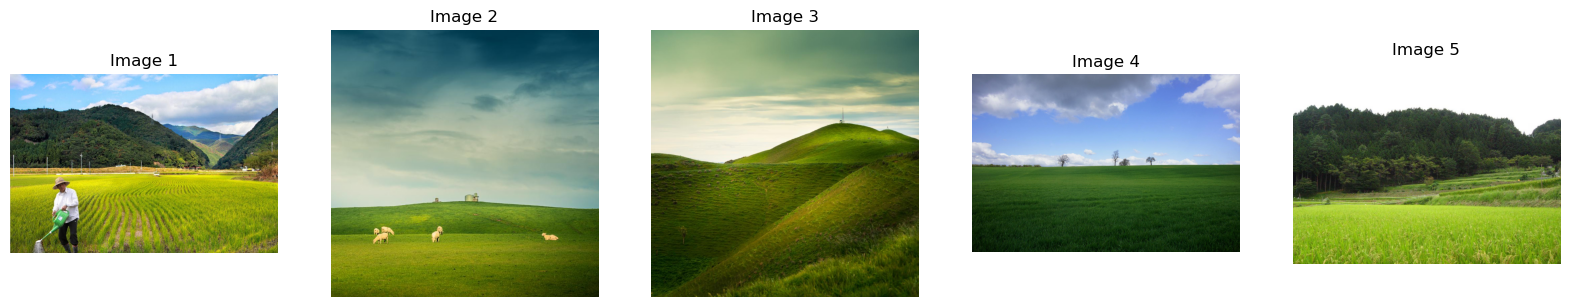

Top 5 Similar Images:


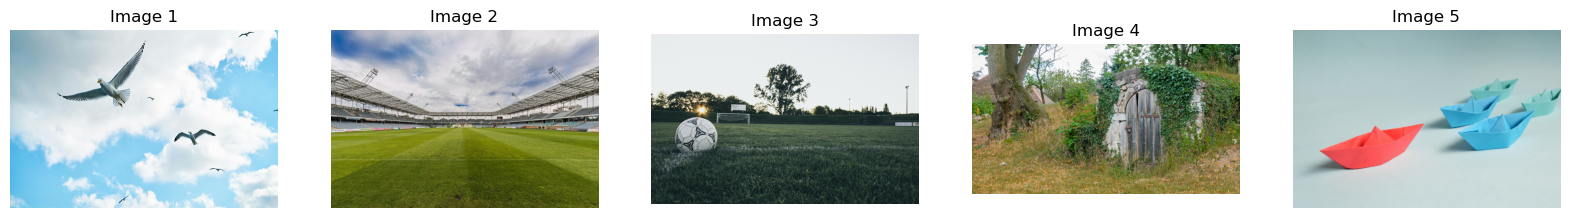

In [10]:
input_image_paths = [
    "D:/data/image_data/Landscapes/00000004_(7).jpg",
    "D:/data/image_data/Landscapes/00000026.jpg",
    "D:/data/image_data/Landscapes/00000001.jpg",
    "D:/data/image_data/Landscapes/00000052.jpg",
    "D:/data/image_data/Landscapes/00000062_(6).jpg"
]


# Extract the first element of each tuple to get the actual file paths


similar_images = find_most_similar_to_average(input_image_paths, histograms, database_image_paths, top_n=5)

top_5_paths_from_5_images = [img_path for img_path, _ in similar_images]

print(similar_images)
print(top_5_paths_from_5_images)

print("Input Images:")
functions.display_images_from_paths(input_image_paths)

print("Top 5 Similar Images:")
functions.display_images_from_paths(top_5_paths_from_5_images)